In [85]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import timeit

### <font color='068090'>Simple convolution example</font>

In [86]:
img = np.array([
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
])

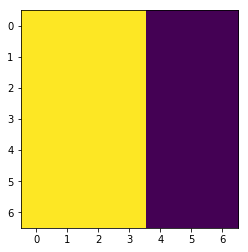

In [87]:
plt.imshow(img)

In [88]:
W = np.array([
    [1, 0, -1], 
    [1, 0, -1], 
    [1, 0, -1]
])

In [89]:
n = img.shape[0]
f = W.shape[0]
p = 0
s = 1
a = int((n+2*p-f)/s)+1

In [90]:
y = np.zeros((a,a))

In [91]:
for i in range(a):
    for j in range(a):
        y[i, j] = np.sum((img[i:i+f,j:j+f]*W))

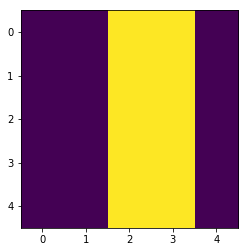

In [92]:
plt.imshow(y)

### <font color='068090'> Basic convolution layer forwardprop and backprop </font> 

#### Defining test

Defining input parameters

In [93]:
m = 12
nh_0 = 64
nw_0 = 64
nc_0 = 3

In [96]:
A0 = np.random.rand(m, nh_0, nw_0, nc_0)

Defining layer parameters

In [97]:
from meik.utils.activations import relu, drelu

In [98]:
fh = 5
fw = 7
nc = 10
s = 1
ph = 0
pw = 0
g = relu
dg = drelu

In [99]:
nh = int((nh_0+2*ph-fh)/s)+1
nw = int((nw_0+2*pw-fw)/s)+1

Defining layer variables

In [100]:
W = np.random.rand(fh, fw, nc_0, nc)

In [101]:
b = np.random.rand(1, 1, 1, nc)

#### Computing forwardprop

In [109]:
def forwardprop_v1(A_0, params):
    
    W, b, g, fh, fw, s, nh, nw, nc = params
    
    Z = np.zeros((m,nh,nw,nc))
    
    for i in range(nh):
        
        for j in range(nw):
            
            axes = tuple(i for i in range(1,len(Z.shape)))
            
            # Note on np.newaxis: extension of A dimension such that it is copied along the additional axis for multiplication
            Z[:, i, j, :] = np.sum((A_0[:,i*s:i*s+fh,j*s:j*s+fw,:,np.newaxis]*W), axis=axes)
            
    Z += b
    
    A = g(Z)

    return A

In [110]:
A = forwardprop_v1(A0, [W, b, g, fh, fw, s, nh, nw, nc])

In [106]:
timeit('forwardprop_v1(A0, [W, b, g, fh, fw, s, nh, nw, nc])', globals=globals(), number=10)/10

0.2257048115017824

#### Computing backprop v1

In [115]:
def backprop_v1(dA0, params):
    
    A, A0, W, dg = params
    
    m, nh_0, nw_0, nc_0 = A0.shape
    fh, fw, _, nc = W.shape
    
    dZ = dg(A)*dA0
    
    axes = tuple(i for i in range(0,len(dZ.shape)-1))
    db = 1./m * np.sum(dZ, axis=axes, keepdims=True)
    
    dW = np.zeros(W.shape)
    dA = np.zeros(A0.shape)
    
    for i in range(nh):

        for j in range(nw):

                A0_ = A0[:,i:i+fh,j:j+fw,:,np.newaxis]
                dZ_ = dZ[:,i,j,:][:,np.newaxis,np.newaxis,np.newaxis,:] 

                dW += np.sum(A0_*dZ_, axis=0, keepdims=False)

                W_ = W[np.newaxis]

                dA[:,i:i+fh,j:j+fw,:] += np.sum(W_*dZ_, axis=4, keepdims=False)

    dW *= 1./m
    
    return dA, dW, db

In [116]:
dA0 = np.random.random(A.shape)

In [117]:
dA, dW, db = backprop_v1(dA0, [A, A0, W, dg])

In [119]:
timeit('backprop_v1(dA0, [A, A0, W, dg])', globals=globals(), number=10)/10

0.3966755288944114

#### Convolution as matrix multiplication

An easier to understand implementation using matrix multiplication: http://cs231n.github.io/convolutional-networks/

In [121]:
def im2col(A, fh, fw, s):
    
    m, nh_0, nw_0, nc_0 = A.shape
    
    nh = int((nh_0-fh)/s)+1
    nw = int((nw_0-fw)/s)+1
    
    out = np.zeros((m, fh*fw*nc_0, nh*nw))
    
    for i in range(nh):

        for j in range(nw):

               out[:, :, i*nw+j] = A[:,i*s:i*s+fh,j*s:j*s+fw,:].reshape(m, fh*fw*nc_0)
                
    return out

In [128]:
def forwardprop_col(A0, params):
    
    W, b, g, fh, fw, s, nh, nw, nc = params
    
    A0_col = im2col(A0, fh, fw, s)
    
    m, _, _, nc_0 = A0.shape
    
    W = W.reshape(fh*fw*nc_0,nc).T
    
    Z = np.zeros((m, nh, nw, nc))
    
    for i in range(m):
        
        Z[i] = np.dot(W,A0_col[i]).T.reshape(1, nh, nw, nc)
        
    Z += b
    
    A = g(Z)
    
    return A
    

In [129]:
A0_col = im2col(A0, fh, fw, s)

In [130]:
A = forwardprop_col(A0, [W, b, g, fh, fw, s, nh, nw, nc])

Checking if it produces the same result as previous implementation:

In [131]:
np.all(A_1 == A)

True

Testing the speed:

In [132]:
timeit('forwardprop_col(A0, [W, b, g, fh, fw, s, nh, nw, nc])', globals=globals(), number=100)/100

0.06546137211029418

A point to note is that im2col seems to take the majority of the computation. Can this be done more efficiently?

In [133]:
timeit('im2col(A0, fh, fw, s)', globals=globals(), number=100)/100

0.05882698010012973

### <font color='068090'> An attempt to improve im2col speed </font> 

####  2D case

Idea from: https://stackoverflow.com/questions/30109068/implement-matlabs-im2col-sliding-in-python/30110497

Generating a 2D test case

In [134]:
V = np.arange(15)[:,None]*5+np.arange(5)
f = 3
s = 1

In [135]:
def im2col_2d(A, f, s):
    
    nh_0, nw_0 = A.shape
    
    nh = int((nh_0-f)/s)+1
    nw = int((nw_0-f)/s)+1
    
    out = []
    
    for i in range(nh):

        for j in range(nw):

               out.append(A[i*s:i*s+f,j*s:j*s+f].flatten())
                
    return np.array(out).flatten()

In [136]:
def im2col_2d_idxs_bc(nh_0, nw_0, f, s):
      
    nh = int((nh_0-f)/s)+1
    nw = int((nw_0-f)/s)+1
    
    # generating indexes of filter window on flattened 2D image
    # for location (0,0) in the output image
    filter_idxs = np.arange(f)[:,np.newaxis]*nw_0 + np.arange(f)

    # generating the index in the flattened 2D image where the filter starts
    # for each location in the output image
    offset_idxs = (np.arange(nh)*s*nw_0)[:,np.newaxis] + np.arange(nw)*s
    
    # generating the full set of indices by generating a set of filter indices
    # for each start location 
    idxs = (offset_idxs.flatten()[:,np.newaxis]+filter_idxs.flatten()).flatten()
    
    return idxs

In [137]:
def im2col_2d_bc(A, f, s):
    
    nh_0, nw_0 = A.shape
    
    idxs = im2col_2d_idxs_bc(nh_0, nw_0, f, s)
    
    return A.flatten()[idxs]

Checking the two implementations produce the same result

In [138]:
np.all(im2col_2d_bc(V,f,s) == im2col_2d(V,f,s))

True

Timing the functions

In [139]:
timeit('im2col_2d(V, f, s)', globals=globals(), number=10000)/10000

8.158772509777919e-05

In [140]:
timeit('im2col_2d_idxs_bc(V.shape[0], V.shape[1], f, s)', globals=globals(), number=10000)/10000

2.4986171995988115e-05

In [141]:
timeit('im2col_2d_bc(V, f, s)', globals=globals(), number=10000)/10000

2.507368079968728e-05

Strategy of using broadcasting is faster according to this simple test. It seems reasonable to extend to 3D. But its important to note that the generation of the indexes takes a significant portion of the time and this only needs to be done once per layer at initialization!

#### Extending to 3D

Generating test case

In [142]:
m = 2
nh_0 = 4
nw_0 = 6
nc_0 = 3

In [143]:
A0 = np.arange(m*nh_0*nw_0*nc_0).reshape(m, nh_0, nw_0, nc_0)

In [144]:
# each channel contains a 2D feature image
A0[0,:,:,0]

array([[ 0,  3,  6,  9, 12, 15],
       [18, 21, 24, 27, 30, 33],
       [36, 39, 42, 45, 48, 51],
       [54, 57, 60, 63, 66, 69]])

In [147]:
fh = 2
fw = 3
nc = 5
s = 1

In [148]:
nh = int((nh_0-fh)/s)+1
nw = int((nw_0-fw)/s)+1

In [149]:
def im2col_3d_idxs_bc(nh_0, nw_0, nc_0, fh, fw, s):
    
    nh = int((nh_0-fh)/s)+1
    nw = int((nw_0-fw)/s)+1
    
    filter_idxs = ((np.arange(fh)[:,None]*nw_0*nc_0 + np.arange(fw)*nc_0)[:,:,None] + np.arange(nc_0)).flatten()
    
    offset_idxs = ((np.arange(nh)*s*nw_0*nc_0)[:,None] + np.arange(nw)*s*nc_0).flatten()
    
    idxs = offset_idxs[:,None] + filter_idxs
    
    return idxs

In [156]:
def im2col_bc(A,fh,fw,s,idxs=None):
    
    m, nh_0, nw_0, nc_0 = A.shape
    
    nh = int((nh_0-fh)/s)+1
    nw = int((nw_0-fw)/s)+1
    
    if type(idxs)==type(None):
        idxs = im2col_3d_idxs_bc(nh_0, nw_0, nc_0, fh, fw, s)
    
    # Note: arranging colums where channels are appended to each other pixel by pixel
    return np.swapaxes(A0.reshape(m,nh_0*nw_0*nc_0)[:,idxs].reshape(m,nh*nw,fh*fw*nc_0),1,2)

In [157]:
# arranging colums where each 2D image is flattened then appended channel by channel
# np.swapaxes(A0.reshape(m,nh_0*nw_0,nc_0)[0,idxs,:].reshape(nw*nh,f*f,nc_0),1,2).reshape(nw*nh,f*f*nc_0).T

Testing that the two methods produce the same result

In [158]:
A0_col = im2col(A0,fh,fw,s)

In [159]:
A0_col_bc = im2col_bc(A0,fh,fw,s)

In [160]:
np.all(A0_col == A0_col_bc)

True

Testing speed of new implementation

In [162]:
timeit('im2col(A0,fh,fw,s)', globals=globals(), number=10000)/10000

3.1880290602566675e-05

In [163]:
timeit('im2col_bc(A0,fh,fw,s)', globals=globals(), number=10000)/10000

3.9462106500286606e-05

The speed improvement is not significant when indexes have to be generated. However, what about in the case that they have already been calculated?

In [166]:
idxs = im2col_3d_idxs_bc(nh_0, nw_0, nc_0, fh, fw, s)

In [168]:
timeit('im2col_bc(A0, fh, fw, s, idxs=idxs)', globals=globals(), number=100000)/100000

8.626543509890326e-06

We experience a fair speedup with the new method!

### <font color='068090'> Convolution backprop as matrix multiplication </font>  

In [197]:
from meik.utils.activations import relu, drelu
from meik.utils.convolution import im2col_idxs

In [198]:
m = 2
nh_0 = 4
nw_0 = 6
nc_0 = 3

In [199]:
A0 = np.arange(m*nh_0*nw_0*nc_0).reshape(m, nh_0, nw_0, nc_0)

In [200]:
fh = 2
fw = 3
nc = 5
s = 1

In [201]:
nh = int((nh_0-fh)/s)+1
nw = int((nw_0-fw)/s)+1

In [202]:
W = np.random.rand(fh, fw, nc_0, nc)
b = np.random.rand(1, 1, 1, nc)

In [203]:
g = relu
dg = drelu

In [204]:
A = forwardprop(A0, [W, b, g, fh, fw, s, nh, nw, nc])

In [205]:
dA0 = np.arange(m*nh*nw*nc).reshape(m, nh, nw, nc)

In [206]:
idxs = im2col_idxs(nh_0, nw_0, nc_0, fh, fw, s)

In [207]:
def backprop_col(dA0, params):
    
    A, A0, A0_col, W, dg, idxs = params
    
    m, nh_0, nw_0, nc_0 = A0.shape
    fh, fw, _, nc = W.shape
    
    nh = int((nh_0-fh)/s)+1
    nw = int((nw_0-fw)/s)+1
    
    dZ = dA0*dg(A)
            
    W_ = W.reshape(fh*fw*nc_0, nc)
    dZ_ = np.swapaxes(dZ.reshape(m, nh*nw, nc),1,2)
    
    dW_ = np.zeros(W_.shape)
    dA_col = np.zeros(A0_col.shape)
    
    axes = tuple(np.arange(len(dZ.shape)-1))
    db = 1./m * np.sum(dZ, axis=axes, keepdims=True)
    
    for i in range(m):
        
        dA_col[i] = np.dot(W_, dZ_[i])
        dW_ += np.dot(A0_col[i], dZ_[i].T)
    
    dW_ *= 1./m

    dA = np.zeros(A0.shape).flatten()
    
    # col2im_v1: doesn't seem efficient since we have to loop -> issue of no accumulation with fancy indexing
    #    for i in range(nw*nh):
    #        dA[:, idxs[i,:]] += dA_col[:,:,i]
 
    # col2im_v2: using np.ufunc.at
    # generating indices for flattening across training examples
    idxs_m = ((np.arange((m),dtype=np.int8)*nh_0*nw_0*nc_0)[:,None] + idxs.flatten()).flatten()
    
    # flattening where features (f x f x nc_0), then training examples, are concatenated
    dA_col = np.swapaxes(dA_col,1,2).flatten()
    
    # adds dA_col to the correct location in the input volume 
    # by accumulating the result for elements that are indexed multiple times
    np.add.at(dA, idxs_m, dA_col)
    
    dA = dA.reshape(A0.shape)
    
    return dA, dW_.reshape(fh,fw,nc_0, nc), db

In [208]:
dA, dW, db = backprop_col(dA0, [A, A0, A0_col, W, dg, idxs])

In [210]:
dA1, dW1, db1 = backprop_v1(dA0, [A, A0, W, dg])

Checking the two backprop methods produce the same result

In [214]:
np.all((dA - dA1) < 1e-12)

True

Timing the two versions

In [215]:
timeit('backprop_col(dA0, [A, A0, A0_col, W, dg, idxs])', globals=globals(), number=10000)/10000

0.00010575936639797873

In [217]:
timeit('backprop_v1(dA0, [A, A0, W, dg])', globals=globals(), number=10000)/10000

0.0004185615554044489

### <font color='068090'> Padding </font>  

In [218]:
m, nh_0, nw_0, nc_0 = (2, 5, 5, 3)

In [219]:
fh, fw, s = (3,3,1)

In [220]:
a = ((np.arange(m)[:,None]*nh_0*nw_0*nc_0 + np.arange(nh_0))[:,:,None]*nw_0*nc_0 + np.arange(nw_0))[:,:,:,None]*nc_0 + np.arange(nc_0)

In [221]:
# 'Same'
ph = (nh_0*(s-1)+fh-s)/2
pw = (nw_0*(s-1)+fw-s)/2

# For 'same' padding ensure the filter size and stride are appropriate: e.g. (nw*(s-1)+fw-s)/2 == 0
assert (ph%1 == 0.0 and pw%1 == 0.0), "Ensure (nw*(s-1)+fw-s)/2 == 0"
ph = int(ph)
pw = int(pw)

In [222]:
def padding(A, ph, pw):

    m, nh_0, nw_0, nc_0 = A.shape

    A_pad = np.zeros((m, nh_0 + 2*ph, nw_0 + 2*pw, nc_0))

    A_pad[:, ph:-ph, pw:-pw, :] = A

    return A_pad

In [223]:
def depadding(A, ph, pw):
    
    m, nh_0, nw_0, nc_0 = A.shape
    
    A_depad = np.zeros((m, nh_0 - 2*ph, nw_0 - 2*pw, nc_0))
    
    A_depad = A[:, ph:-ph, pw:-pw, :]
    
    return A_depad

In [224]:
a_pad = padding(a, ph, pw)

In [225]:
a_depad = depadding(a_pad, ph, pw)

In [226]:
np.all(a_depad == a)

True

### <font color='068090'> Convolution layer class </font>  

Putting it all together

In [77]:
import numpy as np
from meik.layers import Convolution3D

In [78]:
m = 12
nh_0 = 64
nw_0 = 64
nc_0 = 1

In [79]:
A0 = np.random.rand(m, nh_0, nw_0, nc_0)

In [80]:
kernel = (4, 7)
nc = 10
s = 3
padding = 'valid'

In [81]:
# filters, kernel_size = (3,3), stride = 1, padding = 'valid', inputs = None, units = None, activation = None, initialization = None, init_params = None
L1 = Convolution3D(nc, kernel, stride = s, padding = padding, activation = 'relu', inputs = (nh_0, nw_0, nc_0))

In [82]:
L1.init(0, (nh_0, nw_0, nc_0))

Testing forwardprop

In [83]:
A1 = L1.forwardprop(A0)

Testing backprop

In [84]:
dA, idxs_m = L1.backprop(A1)

### Pooling layer

Objective: implement pool layer
1. What does a pool layer do?

### Flatten layer

Objective: implement flatten layer
1. What is the flatten function?
2. What is the inverse flatten function?

### MNIST

Obtaining dataset

In [49]:
from keras.datasets import mnist

Using TensorFlow backend.


In [50]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

One-hot encoding labels

In [51]:
def one_hot_encode(y):
    
    shape = tuple(list(y.shape)+[np.max(y)+1])
    l = np.zeros(shape)
    
    l[np.arange(l.shape[0]),y] = 1
    
    return l

In [52]:
Y_train = one_hot_encode(y_train).T

In [53]:
Y_test = one_hot_encode(y_test).T

Flattening inputs

In [54]:
m, h, w = x_train.shape

In [55]:
X_train = x_train.reshape(m, h*w).T

In [56]:
n, h, w = x_test.shape

In [57]:
X_test = x_test.reshape(n, h*w).T

### MNIST With fully connected

In [58]:
from meik.models import Sequential
from meik.layers import Layer, Dense, Dropout, Batch_norm

In [59]:
model = Sequential()

In [60]:
model.add(Dense(units=64, activation='relu', inputs=28*28))
model.add(Batch_norm())
model.add(Dense(units=32, activation='relu'))
model.add(Batch_norm())
model.add(Dense(units=16, activation='relu'))
model.add(Batch_norm())
model.add(Dense(units=10, activation='softmax'))

In [61]:
from meik import optimizers
optimizer = optimizers.Adam()

In [62]:
metrics = ['accuracy', 'binary_crossentropy', 'confusion_matrix']

In [63]:
model.build(loss='categorical_crossentropy', optimizer=optimizer, eval_metrics=metrics)

In [64]:
X_train.shape

(784, 60000)

In [65]:
model.train(X_train, Y_train, batch_size=64, epochs=1, verbose=1)

Epoch 1/1 - loss_tot: 0.2722 - reg_loss: 0.0000 - categorical_crossentropy: 0.2722
------------ Final performance ------------

Epoch 1/1 - loss_tot: 0.2722 - reg_loss: 0.0000 - categorical_crossentropy: 0.2722


In [66]:
from meik.utils.misc import plot_training_loss

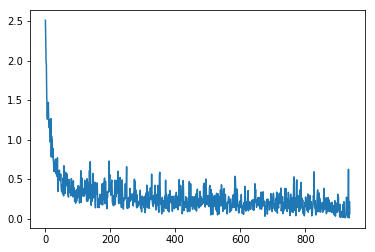

In [67]:
plot_training_loss(model, loss=model.params['loss'], mode='batch')

In [68]:
score = model.evaluate(X_test,Y_test)

### MNIST with Convolution3D

In [69]:
from meik.models import Sequential
from meik.layers import Convolution3D, Dense
from meik.utils import gradient_check

In [73]:
model = Sequential()

In [75]:
model.add(Convolution3D(8, (3,3), stride = 1, padding = 'valid', activation = 'relu', inputs = (nh_0, nw_0, nc_0)))